<a href="https://colab.research.google.com/github/HovhannesArustamyan/optuna_with_random_forest/blob/master/task_Hovhannes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.4 MB/s eta 0:00:00


In [152]:
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import  confusion_matrix, roc_auc_score, precision_recall_curve, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
X = pd.read_csv('/content/drive/MyDrive/task_artsai/interview.X.csv')

In [3]:
y = pd.read_csv('/content/drive/MyDrive/task_artsai/interview.y.csv')

In [4]:
data = pd.merge(X, y, how='inner', on='uid')

In [5]:
data

,reg_time,uid,fc_imp_chk,fc_time_chk,utmtr,mm_dma,osName,model,hardware,site_id,tag
0,2021-07-21 19:29:20,00000000-0000-0001-6268-957597321099,0,7,6,517,Android,SM-N960U,Mobile Phone,dotesports.com,vcontent
1,2021-07-21 19:29:54,00000000-0000-0001-6268-957946481763,0,7,6,505,Android,Pixel 4a,Mobile Phone,online.seterra.com,vregistration
2,2021-07-21 19:30:05,00000000-0000-0001-6268-958052831367,0,7,6,501,iOS,iPhone,Mobile Phone,hiphopdx.com,vregistration
3,2021-07-21 19:30:05,00000000-0000-0001-6268-958052831367,0,7,6,501,iOS,iPhone,Mobile Phone,hiphopdx.com,vregistration
4,2021-07-21 19:30:15,00000000-0000-0001-6268-958153731939,0,7,6,517,Android,SM-G991U,Mobile Phone,www.vivaelbirdos.com,vregistration
...,...,...,...,...,...,...,...,...,...,...,...
15387,2021-08-06 15:18:15,00000000-0000-0001-6282-630943861926,0,7,5,556,iOS,iPhone,Mobile Phone,www.digitalspy.com,fclick
15388,2021-08-06 15:18:15,00000000-0000-0001-6282-630943861926,0,7,5,556,iOS,iPhone,Mobile Phone,www.digitalspy.com,registration
15389,2021-08-06 15:27:50,00000000-0000-0001-6282-636710091771,1,6,5,0,Android,SM-G975U,Mobile Phone,www.digitalspy.com,fclick
15390,2021-08-06 16:05:52,00000000-0000-0001-6282-626705991151,3,6,5,567,iOS,iPhone,Mobile Phone,whatculture.com,vregistration


***Анализ пропущенных значений***

In [6]:
data.isnull().sum()

,0
reg_time,0
uid,0
fc_imp_chk,0
fc_time_chk,0
utmtr,0
mm_dma,0
osName,133
model,138
hardware,138
site_id,0


***Статистическое описание цифровых данных***

In [8]:
data.describe()

,fc_imp_chk,fc_time_chk,utmtr,mm_dma
count,15392.000000,15392.000000,15392.000000,15392.000000
mean,0.186525,6.915281,3.508966,511.297492
std,0.715600,0.278473,2.375218,149.653718
min,0.000000,6.000000,0.000000,0.000000
25%,0.000000,7.000000,1.000000,505.000000
50%,0.000000,7.000000,4.000000,524.000000
75%,0.000000,7.000000,6.000000,561.000000
max,4.000000,7.000000,7.000000,881.000000


***Распределение категориальных переменных***

In [20]:
categorical_cols = ['fc_imp_chk', 'fc_time_chk', 'utmtr', 'osName', 'model', 'hardware', 'site_id']
for col in categorical_cols:
    print(data[col].value_counts())
    print('-' * 50)

fc_imp_chk
0    14088
1      599
4      344
2      187
3      174
Name: count, dtype: int64
--------------------------------------------------
fc_time_chk
7    14088
6     1304
Name: count, dtype: int64
--------------------------------------------------
utmtr
0    2798
4    2324
5    2299
6    2136
7    1729
3    1693
1    1605
2     808
Name: count, dtype: int64
--------------------------------------------------
osName
iOS           8889
Android       6110
Windows 10     237
Windows 7       15
Symbian          5
Linux            3
Name: count, dtype: int64
--------------------------------------------------
model
iPhone              7871
SM-G973U             300
SM-G991U             271
SM-G975U             260
Chrome - Windows     244
                    ... 
SM-A505F               1
SM-F900U               1
One Fusion Plus        1
SM-A205U1              1
Alpha 20               1
Name: count, Length: 365, dtype: int64
--------------------------------------------------
hardware
Mobil

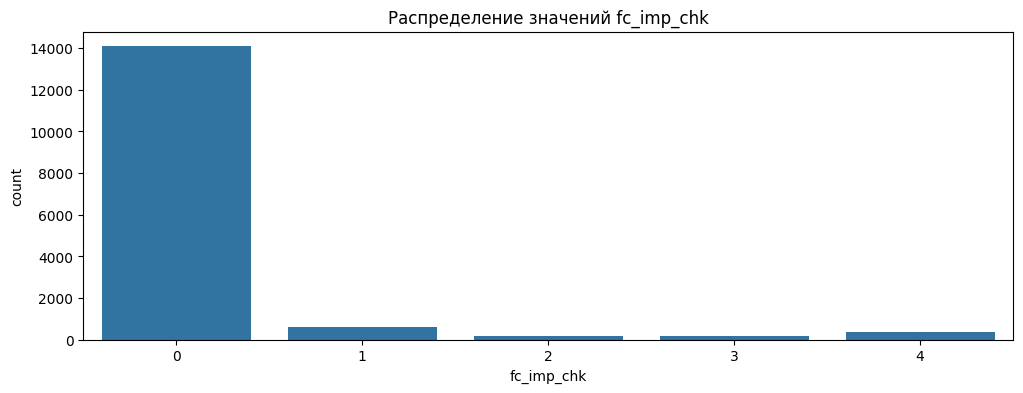

In [21]:
plt.figure(figsize=(12, 4))
sns.countplot(x='fc_imp_chk', data=data)
plt.title('Распределение значений fc_imp_chk')
plt.show()

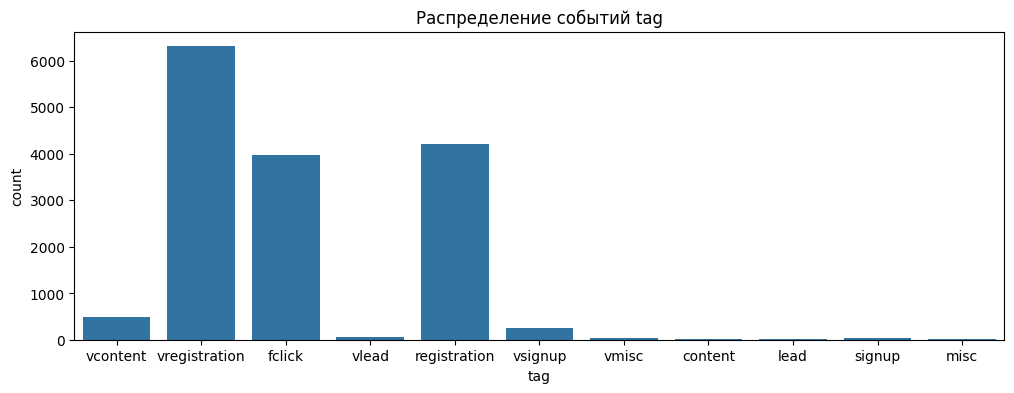

In [22]:
plt.figure(figsize=(12, 4))
sns.countplot(x='tag', data=data)
plt.title('Распределение событий tag')
plt.show()

***Корреляционный анализ***

***Преобразование категориальных переменных в числовые***

In [23]:
from sklearn.preprocessing import LabelEncoder

In [24]:
label_cols = ['osName', 'model', 'hardware', 'site_id']
le = LabelEncoder()
for col in label_cols:
    data[col] = le.fit_transform(data[col])

***Преобразуем tag в бинар через One-Hot Encoding***

In [26]:
transformed_data = pd.get_dummies(data, columns=['tag'],drop_first=True)

***False True --> 0 1***

In [27]:
transformed_data.loc[:, 'tag_fclick':] = transformed_data.loc[:, 'tag_fclick':].astype(int)

***Выбираем числовые признаки для показа (fc_imp_chk, fc_time_chk, utmtr и другие)***

In [28]:
numerical_columns = ['fc_imp_chk', 'fc_time_chk', 'utmtr']

***Выбираем бинарные признаки событий***

In [29]:
tag_columns = [col for col in transformed_data.columns if col.startswith('tag_')]

In [31]:
corr_matrix = transformed_data[numerical_columns + tag_columns].corr()

***Отображаем корреляцию  между показами и событиями***

In [32]:
corr_subset = corr_matrix.loc[numerical_columns, tag_columns]

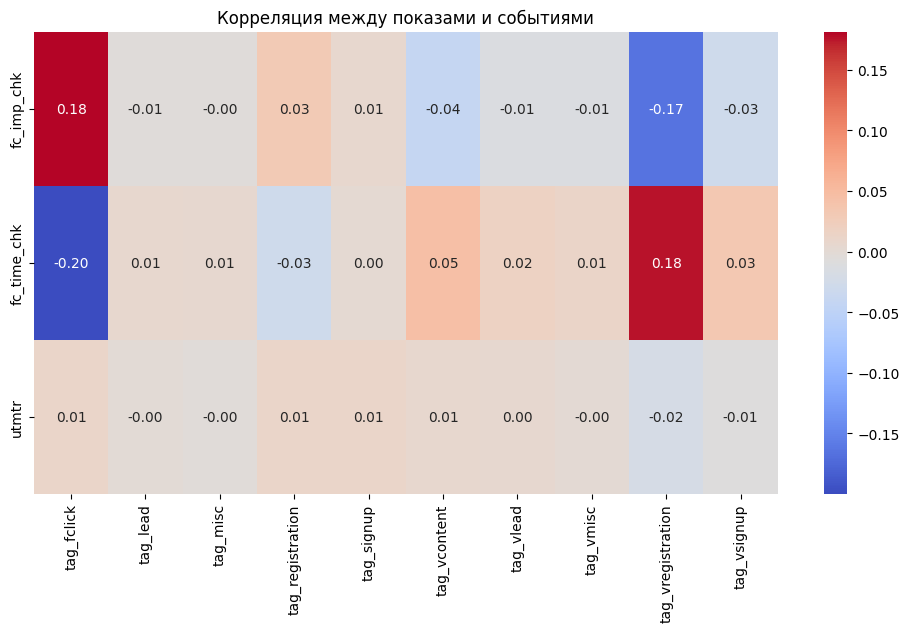

In [33]:
plt.figure(figsize=(12, 6))
sns.heatmap(corr_subset, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляция между показами и событиями')
plt.show()

***Создание целевой переменной (1 - fclick, 0 - остальные)***

In [34]:
data['target'] = (data['tag'] == 'fclick').astype(int)

In [35]:
data = data.drop(['reg_time', 'uid', 'tag'], axis=1)

In [36]:
data

,fc_imp_chk,fc_time_chk,utmtr,mm_dma,osName,model,hardware,site_id,target
0,0,7,6,517,0,286,2,155,0
1,0,7,6,505,0,158,2,438,0
2,0,7,6,501,5,341,2,259,0
3,0,7,6,501,5,341,2,259,0
4,0,7,6,517,0,258,2,1372,0
...,...,...,...,...,...,...,...,...,...
15387,0,7,5,556,5,341,2,834,1
15388,0,7,5,556,5,341,2,834,0
15389,1,6,5,0,0,247,2,834,1
15390,3,6,5,567,5,341,2,637,0


In [37]:
data.isnull().sum()

,0
fc_imp_chk,0
fc_time_chk,0
utmtr,0
mm_dma,0
osName,0
model,0
hardware,0
site_id,0
target,0


In [38]:
X = data.drop('target', axis=1)
y = data['target']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

***Так как корреляции нету можно выбрать нелинейные модели.***

In [117]:
model = RandomForestClassifier()

In [130]:
cv = RepeatedStratifiedKFold(n_splits=5)

In [133]:
scores = cross_val_score(model, X_train, y_train, cv=cv)

In [134]:
print(scores)

[0.67032075 0.66788469 0.67803492 0.66328188 0.6661251  0.66098254
 0.65976451 0.66057653 0.68643379 0.66206336 0.68087698 0.68859115
 0.67032075 0.67343623 0.66125102 0.66423061 0.66707268 0.67600487
 0.66531275 0.66815597 0.64839626 0.67762891 0.6638246  0.67099919
 0.66409423 0.66666667 0.67194478 0.65732846 0.67871649 0.6738424
 0.66910272 0.65164434 0.66098254 0.65881397 0.66450041 0.65489241
 0.67438084 0.65042631 0.67221771 0.67221771 0.66301259 0.66057653
 0.66950873 0.6754671  0.6754671  0.65814048 0.65489241 0.67235079
 0.67952884 0.66693745]


In [135]:
print('Mean ROC AUC: %.5f' % scores.mean())

Mean ROC AUC: 0.66738


***Сделаем тюнинг гиперпараметров , так как у нас есть недообучение***

In [110]:
def objective(trial):
    param = {
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "min_samples_split": trial.suggest_int("min_samples_split", 2 ,5)
    }

    model = RandomForestClassifier(**param)
    score = cross_val_score(model, X_train, y_train, n_jobs=-1,scoring='roc_auc', cv=5).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)
print("Best value:", study.best_value)

[I 2024-12-22 07:19:01,510] A new study created in memory with name: no-name-0db794e3-b758-48cb-b9eb-c4ddabd6d55c
[I 2024-12-22 07:19:14,407] Trial 0 finished with value: 0.7256140496471726 and parameters: {'max_depth': 6, 'n_estimators': 408, 'min_samples_split': 4}. Best is trial 0 with value: 0.7256140496471726.
[I 2024-12-22 07:19:34,603] Trial 1 finished with value: 0.7194674696214742 and parameters: {'max_depth': 5, 'n_estimators': 785, 'min_samples_split': 5}. Best is trial 0 with value: 0.7256140496471726.
[I 2024-12-22 07:20:13,768] Trial 2 finished with value: 0.7308336298267311 and parameters: {'max_depth': 8, 'n_estimators': 974, 'min_samples_split': 3}. Best is trial 2 with value: 0.7308336298267311.
[I 2024-12-22 07:20:31,891] Trial 3 finished with value: 0.7073904565531243 and parameters: {'max_depth': 4, 'n_estimators': 827, 'min_samples_split': 3}. Best is trial 2 with value: 0.7308336298267311.
[I 2024-12-22 07:20:43,801] Trial 4 finished with value: 0.726492079063253

Number of finished trials: 100
Best trial: {'max_depth': 8, 'n_estimators': 142, 'min_samples_split': 5}
Best value: 0.7324680050254473


In [137]:
best_optuna_params = study.best_trial.params
best_optuna_params

{'max_depth': 8, 'n_estimators': 142, 'min_samples_split': 5}

In [138]:
model = RandomForestClassifier(**best_optuna_params)

In [139]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_split=5, n_estimators=142)

In [140]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

In [144]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(roc_auc)

0.7172089357269235


In [153]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

In [159]:
# Находим оптимальный порог по F1-скор
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold_f1 = thresholds[optimal_idx]

print(f"Optimal threshold based on F1-score: {optimal_threshold_f1:.4f}")


Optimal threshold based on F1-score: 0.2524


In [160]:
y_pred_prob = model.predict_proba(X_test)
y_pred_opt = (y_pred_prob[:,1]>=optimal_threshold_f1).astype(int)

In [162]:
print(confusion_matrix(y_test, y_pred_opt))

[[1430  855]
 [ 222  572]]
